In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 训练数据集存放目录
data_dir = 'data/train/'
# 自定义模型文件名
model_name = 'test10'
# 自定义标签分类排序
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
# 创建数据集
batch_size = 10

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  class_names=class_names,
  color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(28, 28),
  batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  class_names=class_names,
  color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(28, 28),
  batch_size=batch_size)

# 标准化数据
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))



Found 60021 files belonging to 11 classes.
Using 48017 files for training.
Found 60021 files belonging to 11 classes.
Using 12004 files for validation.


In [12]:
# 查看类名称
print('train labels: ', train_ds.class_names)
print('valid labels: ', valid_ds.class_names)

assert train_ds.class_names == class_names
assert valid_ds.class_names == class_names

train labels:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
valid labels:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


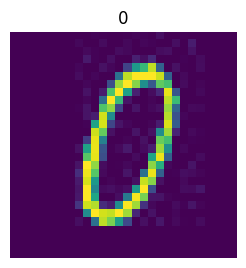

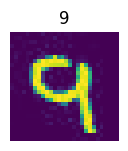

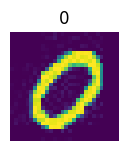

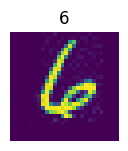

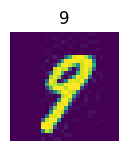

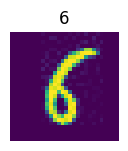

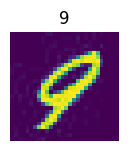

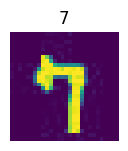

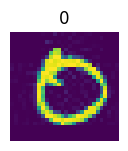

train images:  (10, 28, 28, 1)
train labels:  (10,)
valid labels:  (10, 28, 28, 1)
valid labels:  (10,)


In [25]:
# 呈现数据
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.show()

# 检索当前的数据
for image_batch, labels_batch in train_ds:
  print('train images: ', image_batch.shape)
  print('train labels: ', labels_batch.shape)

  assert image_batch.shape[0] == labels_batch.shape[0]
  assert image_batch.shape[1] == 28
  assert image_batch.shape[2] == 28
  assert image_batch.shape[3] == 1
  break

for image_batch, labels_batch in valid_ds:
  print('valid labels: ', image_batch.shape)
  print('valid labels: ', labels_batch.shape)

  assert image_batch.shape[0] == labels_batch.shape[0]
  assert image_batch.shape[1] == 28
  assert image_batch.shape[2] == 28
  assert image_batch.shape[3] == 1
  break

In [18]:

# 创建模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(len(class_names))
])

In [19]:
# 编译模型
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# 模型摘要
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 101899 (398.04 KB)
Trainable params: 101899 (398.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# 训练模型
epochs = 5
history = model.fit(
  normalized_train_ds,
  validation_data=normalized_valid_ds,
  epochs=epochs
)

Epoch 1/5


4802/4802 [==============================] - 4s 734us/step - loss: 0.2860 - accuracy: 0.9164 - val_loss: 0.1410 - val_accuracy: 0.9575
Epoch 2/5
4802/4802 [==============================] - 4s 730us/step - loss: 0.1426 - accuracy: 0.9568 - val_loss: 0.1147 - val_accuracy: 0.9640
Epoch 3/5
4802/4802 [==============================] - 4s 760us/step - loss: 0.1071 - accuracy: 0.9673 - val_loss: 0.0945 - val_accuracy: 0.9719
Epoch 4/5
4802/4802 [==============================] - 4s 790us/step - loss: 0.0896 - accuracy: 0.9717 - val_loss: 0.0955 - val_accuracy: 0.9731
Epoch 5/5
4802/4802 [==============================] - 4s 728us/step - loss: 0.0763 - accuracy: 0.9758 - val_loss: 0.0904 - val_accuracy: 0.9748


In [22]:
# 保存模型
model.save('tmp/' + model_name + '.keras')

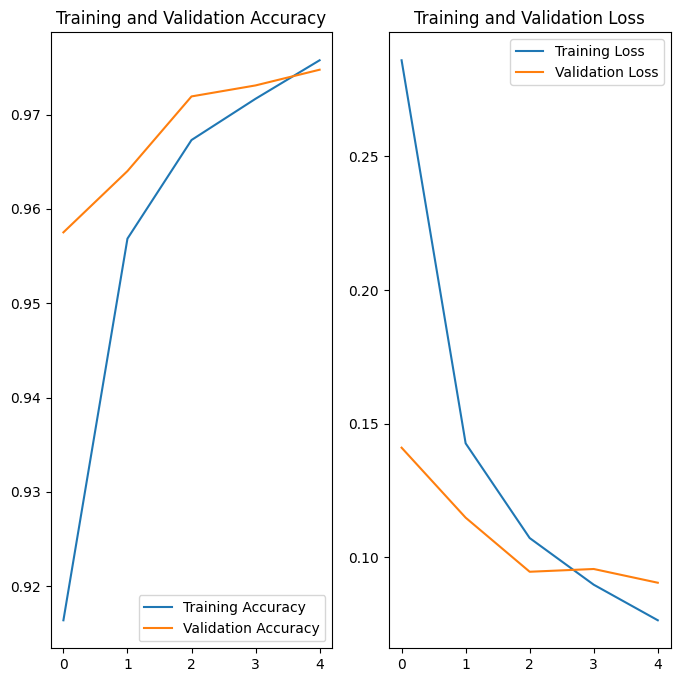

In [23]:
# 呈现训练结果
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# 生成ONNX模型
import tf2onnx
spec = (tf.TensorSpec((None, 28, 28, 1), tf.float32, name="input"),)
output_path = 'onnx/' + model_name + '.onnx'
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]
print(output_names)

['dense_1']
